In [1]:
import os
import json
import pandas as pd
import sys
from collections import defaultdict

In [2]:
data_dir = f"../../data/google_patents/us_patents"
save_data_path = os.path.join(data_dir, "data.ndjson")
stat_dir = "./us_statistics/"
os.makedirs(stat_dir, exist_ok=True)

stat_dict = {}

In [3]:
with open(save_data_path, "r") as f:
    samples = [json.loads(line) for line in f]

df = pd.DataFrame(samples)

## Create statistics report

In [4]:
stat_dict["no. samples"] = len(samples)

In [5]:
labels = set()
for x in samples:
    labels.update(x["labels"])
stat_dict["no. labels"] = len(labels)

In [6]:
sample_label = defaultdict(set)
for x in samples:
    for l in x["labels"]:
        sample_label[l].add(x["id"])

tmp = pd.Series(sample_label).apply(lambda x: len(x)).describe()
stat_dict["no. samples/label"] = "{:.2f} ± {:.2f}".format(tmp["mean"], tmp["std"])

In [7]:
tmp = df["labels"].apply(lambda x: len(x)).describe()
stat_dict["no. labels/sample"] = "{:.2f} ± {:.2f}".format(tmp["mean"], tmp["std"])

In [8]:
content_samples = []
for x in samples:
    content = " ".join((x["abstract"], x["title"], x["claims"], x["description"]))
    content_samples.append(content)

stat_dict["no. words/sample"] = pd.Series(content_samples).apply(lambda text: len(text.split())).mean()

In [9]:
for x in ("abstract", "title", "claim_1", "claims", "description"):
    stat_dict[f"no. words/sample ({x})"] = df[x].apply(lambda text: len(text.split())).mean()

In [10]:
stat_dict

{'no. samples': 45131,
 'no. labels': 425,
 'no. samples/label': '221.69 ± 38.56',
 'no. labels/sample': '2.09 ± 1.31',
 'no. words/sample': 7514.904721809842,
 'no. words/sample (abstract)': 131.05240300458664,
 'no. words/sample (title)': 7.28988943298398,
 'no. words/sample (claim_1)': 154.6793556535419,
 'no. words/sample (claims)': 955.8766922957612,
 'no. words/sample (description)': 6420.685737076511}

In [11]:
stat_report = pd.DataFrame([stat_dict])
stat_report.to_excel(stat_dir + "ja_statistics.xlsx", index=False, float_format="%.2f")
stat_report

,no. samples,no. labels,no. samples/label,no. labels/sample,no. words/sample,no. words/sample (abstract),no. words/sample (title),no. words/sample (claim_1),no. words/sample (claims),no. words/sample (description)
0,45131,425,221.69 ± 38.56,2.09 ± 1.31,7514.904722,131.052403,7.289889,154.679356,955.876692,6420.685737


## Visualise statistics

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

font_dirs = ["../../dotfiles/helvetica/", "../../dotfiles/simhei"]
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
print(font_files)
for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)   
    
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'helvetica'

sns.set_style("ticks")
sns.set_context("paper")

cmap = mpl.cm.get_cmap('Greys_r')
palette = "gray"

['/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica-rounded-bold-5871d05ead8de.otf', '/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica-Oblique.ttf', '/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica-compressed-5871d14b6903a.otf', '/mnt/lustre/home/joanna/dotfiles/simhei/chinese.simhei.ttf', '/mnt/lustre/home/joanna/dotfiles/simhei/SimHei.ttf', '/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica-BoldOblique.ttf', '/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica-Bold.ttf', '/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica.ttf', '/mnt/lustre/home/joanna/dotfiles/helvetica/helvetica-light-587ebe5a59211.ttf']


In [13]:
def compute_frequency(samples):
    freq = {}
    for x in samples:
        for label in x["labels"]:
            freq[label] = freq.get(label, 0) + 1
    return freq

freq = compute_frequency(samples)

In [14]:
tmp = pd.Series(freq).apply(lambda x: round(2 * (x / 100)) / 2).value_counts() 
tmp

2.0    353
3.0     29
2.5     26
3.5     14
4.0      3
dtype: int64

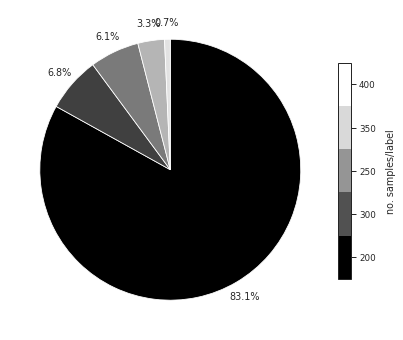

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

n_clusters = len(tmp)
bounds = np.linspace(0, 1, num=n_clusters + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

pie_chart = ax.pie(tmp, startangle=90, autopct="%1.1f%%", pctdistance=1.13, counterclock=False, colors=cmap(bounds));
ax_cbar = fig.add_axes([.9, .25, .03, .5])

cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap, norm=norm, ticks=(np.arange(n_clusters) + 0.5) / n_clusters)
cbar.set_label("no. samples/label")
cbar.set_ticklabels((tmp.index * 100).astype(int))

fig.show()
fig.savefig(stat_dir + "chart_number-samples-per-label.pdf", bbox_inches="tight")

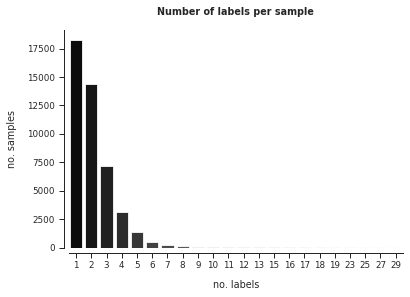

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = sns.countplot(x=df["labels"].apply(lambda x: len(x)), palette=palette);
ax.set_title("Number of labels per sample", weight="bold");
ax.set(xlabel="no. labels", ylabel="no. samples");

ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);
ax.spines['left'].set_position(('outward', 5));
ax.spines['bottom'].set_position(('outward', 5));

fig.show()
fig.savefig(stat_dir + "chart_number-labels-per-sample.pdf", bbox_inches="tight")